In [1]:
from utils import *

BASE_PATH = '../data/world'
NODES_PATH = BASE_PATH + '/world_nodes.txt'
EDGES_PATH = BASE_PATH + '/world_edges.txt'

GraphBuilder = GraphBuilder(NODES_PATH, EDGES_PATH)
graph = GraphBuilder.build_graph()

In [2]:
from sklearn.cluster import KMeans
import numpy as np

def cluster_and_add_warehouses(graph, warehouse_type, n_clusters):
    # Extract node coordinates for clustering
    node_coordinates = np.array([(node.x, node.y) for node in graph.nodes])

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(node_coordinates)
    
    # Initialize clusters
    clusters = [[] for _ in range(n_clusters)]

    # Assign nodes to clusters
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(graph.nodes[i])

    # Calculate centroids
    centroids = [(sum(node.x for node in cluster) / len(cluster), 
                  sum(node.y for node in cluster) / len(cluster)) for cluster in clusters]

    # Create WarehouseNodes and add them to the graph
    for i, centroid in enumerate(centroids):
        new_warehouse = WarehouseNode(f'Warehouse_{i}', centroid[0], centroid[1], warehouse_type)
        graph.add_node(new_warehouse)

    # Connect WarehouseNodes with original clusters
    for i, centroid in enumerate(centroids):
        cluster_nodes = clusters[i]
        for node in cluster_nodes:
            weight = ((node.x - centroid[0])**2 + (node.y - centroid[1])**2)**0.5
            edge_to_warehouse = Edge(node, graph.get_node_by_id(f'Warehouse_{i}'), weight)
            graph.add_edge(edge_to_warehouse)

    return graph, clusters


In [5]:
def assign_warehouses(graph):
        local_criteria, regional_criteria, central_criteria = 100, 10, 3

        graph, clusters_local = cluster_and_add_warehouses(graph, 'local', local_criteria)
        graph, clusters_regional = cluster_and_add_warehouses(graph, 'regional', regional_criteria)
        graph, clusters_central = cluster_and_add_warehouses(graph, 'central', central_criteria)

        graph.plot_graph()
        return graph, clusters_local, clusters_regional, clusters_central

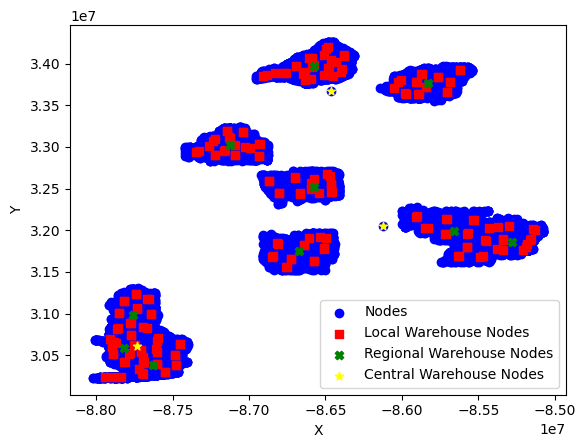

In [6]:
graph, clusters_local, clusters_regional, clusters_central = assign_warehouses(graph)

In [14]:
import os

os.makedirs('../results/clusters/local/')
os.makedirs('../results/clusters/regional/')
os.makedirs('../results/clusters/central/')

In [11]:
i = 0
for loc in clusters_local:
    file_path = f'../results/clusters/local/local_{i}.txt'
    i += 1
    with open(file_path, 'w') as file:
        for node in loc:
            file.write(str(node.id) + ' ' + str(node.x) + ' ' + str(node.y) + '\n')


In [12]:
i = 0
for reg in clusters_regional:
    file_path = f'../results/clusters/regional/regional_{i}.txt'
    i += 1
    with open(file_path, 'w') as file:
        for node in loc:
            file.write(str(node.id) + ' ' + str(node.x) + ' ' + str(node.y) + '\n')

In [13]:
i = 0
for cen in clusters_central:
    file_path = f'../results/clusters/central/central_{i}.txt'
    i += 1
    with open(file_path, 'w') as file:
        for node in loc:
            file.write(str(node.id) + ' ' + str(node.x) + ' ' + str(node.y) + '\n')